In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
df_train = pd.read_csv('/content/train.csv')
train_length = len(df_train)
df_test = pd.read_csv('/content/train.csv')
df_train.rename(columns = {'Personality (Class label)':'Personality'}, inplace = True)
df_test.rename(columns = {'Personality (class label)':'Personality'}, inplace = True)
df = pd.concat([df_train, df_test])
df.head()

,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality,Personality (Class label)
0,Male,17,7,4,7,3,2,extraverted,NaN
1,Male,19,4,5,4,6,6,serious,NaN
2,Female,18,7,6,4,5,5,dependable,NaN
3,Female,22,5,6,7,4,3,extraverted,NaN
4,Female,19,7,4,6,5,4,lively,NaN


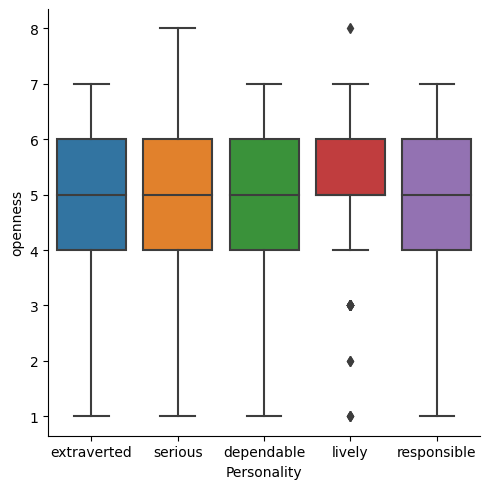

In [4]:
sns.catplot(x="Personality", y="openness", kind="box", data=df)

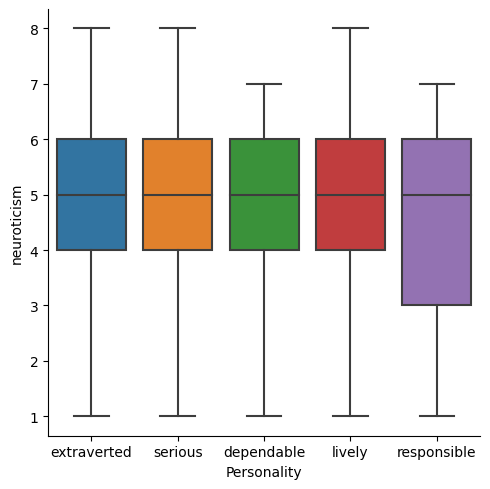

In [5]:
sns.catplot(x="Personality", y="neuroticism", kind="box", data=df)

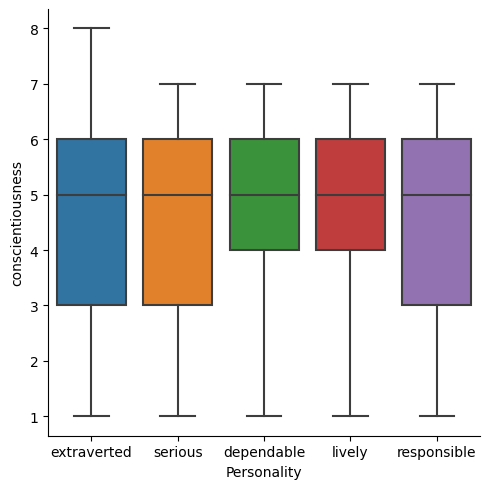

In [6]:
sns.catplot(x="Personality", y="conscientiousness", kind="box", data=df)

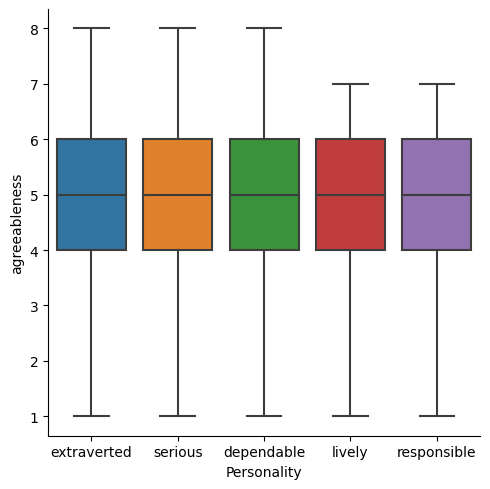

In [7]:
sns.catplot(x="Personality", y="agreeableness", kind="box", data=df)


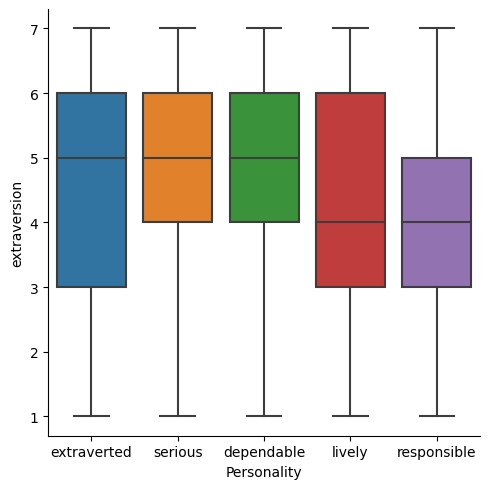

In [8]:
sns.catplot(x="Personality", y="extraversion", kind="box", data=df)

In [9]:
df['Gender'] = df['Gender'].map({'Male': 0,
                                 'Female': 1})

df['Personality'] = df['Personality'].map({'dependable': 0,
                                           'extraverted': 1,
                                           'lively': 2,
                                           'responsible': 3,
                                           'serious': 4})

In [10]:
df[df.isnull().sum(axis=1) > 0]

,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality,Personality (Class label)
0,0.0,17,7,4,7,3,2,1.0,NaN
1,0.0,19,4,5,4,6,6,4.0,NaN
2,1.0,18,7,6,4,5,5,0.0,NaN
3,1.0,22,5,6,7,4,3,1.0,NaN
4,1.0,19,7,4,6,5,4,2.0,NaN
...,...,...,...,...,...,...,...,...,...
704,1.0,20,4,5,6,6,1,NaN,responsible
705,0.0,18,6,3,1,5,5,NaN,dependable
706,0.0,22,5,2,3,6,1,NaN,serious
707,0.0,19,5,6,5,7,5,NaN,extraverted


In [14]:
df_cleaned = df.dropna()


In [23]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Option 3: Imputation using SimpleImputer (mean for numeric, most frequent for categorical)
imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

df_numeric_imputed = pd.DataFrame(imputer_numeric.fit_transform(df[numeric_cols]), columns=numeric_cols)
df_categorical_imputed = pd.DataFrame(imputer_categorical.fit_transform(df[categorical_cols]), columns=categorical_cols)

# Combine the imputed numeric and categorical data
df_imputed = pd.concat([df_numeric_imputed, df_categorical_imputed], axis=1)

# Option 4: Create a missing indicator column
df_imputed['Personality_Missing'] = df_imputed['Personality'].isnull().astype(int)

# Save the modified dataset
df_imputed.to_csv('imputed_dataset.csv', index=False)



In [24]:
# Assuming you have imported pandas and have a DataFrame named df
grouped_mean = df.groupby(by=['Personality', 'Age']).mean()

# Print the result to see its structure
print(grouped_mean)



                   Gender  openness  neuroticism  conscientiousness  \
Personality Age                                                       
0.0         17   0.666667  5.583333     5.000000           4.833333   
            18   0.656250  5.062500     4.937500           4.562500   
            19   0.590909  4.840909     4.545455           4.704545   
            20   0.533333  5.133333     4.866667           5.533333   
            21   0.545455  5.090909     4.363636           4.454545   
...                   ...       ...          ...                ...   
4.0         24   0.500000  5.000000     4.333333           5.000000   
            25   0.250000  6.000000     4.000000           5.500000   
            26   0.500000  4.000000     5.500000           4.000000   
            27   0.000000  7.000000     5.000000           6.000000   
            28   0.000000  1.000000     5.000000           6.000000   

                 agreeableness  extraversion  
Personality Age              

In [25]:
df.at[449, 'Gender'] = 0

<Axes: >

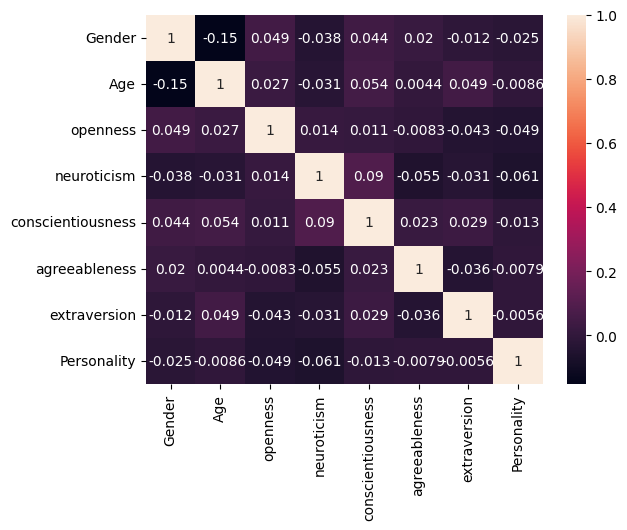

In [26]:
sns.heatmap(df.corr(), annot=True)

In [27]:
df.skew()

Gender              -0.144391
Age                  0.671803
openness            -0.653438
neuroticism         -0.485692
conscientiousness   -0.415880
agreeableness       -0.625084
extraversion        -0.327348
Personality          0.010882
dtype: float64

In [28]:
df['openness'] = np.sqrt(max(df['openness']+1) - df['openness'])
df['agreeableness'] = np.sqrt(max(df['agreeableness']+1) - df['agreeableness'])
df.skew()

Gender              -0.144391
Age                  0.671803
openness             0.258086
neuroticism         -0.485692
conscientiousness   -0.415880
agreeableness        0.221718
extraversion        -0.327348
Personality          0.010882
dtype: float64

In [29]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming you have a DataFrame named df with appropriate data

# Split the DataFrame into training and testing sets
train_length = 3
df_train = df[:train_length]
df_test = df[train_length:]

# Extract target variable (Y) and features (X) from the training set
Y = df_train.iloc[:, -1]
X = df_train.iloc[:, :-1]

# Extract target variable (Y_test) and features (X_test) from the testing set
Y_test = df_test.iloc[:, -1]
X_test = df_test.iloc[:, :-1]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the preprocessor on the training data
X_scaled = preprocessor.fit_transform(X)

# Use the preprocessor to transform the testing data
X_test_scaled = preprocessor.transform(X_test)



In [30]:
df_train['Personality'].value_counts() / len(df_train)

1.0    0.333333
4.0    0.333333
0.0    0.333333
Name: Personality, dtype: float64

In [31]:
df_test['Personality'].value_counts() / len(df_test)

4.0    0.113074
1.0    0.105300
0.0    0.096820
2.0    0.094700
3.0    0.089046
Name: Personality, dtype: float64

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the data into features (X) and target labels (y)
X = df_imputed.drop(columns=['Personality', 'Personality (Class label)'])
y = df_imputed['Personality (Class label)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit models
models = {
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

print(results)


{'LogisticRegression': 0.6056338028169014, 'SVC': 0.6056338028169014, 'AdaBoostClassifier': 0.6056338028169014, 'KNeighborsClassifier': 0.6056338028169014}
